In [1]:
from numpy.random import Generator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize 
from scipy.stats import gaussian_kde
from scipy.stats import ks_2samp
from scipy.special import rel_entr
from scipy.stats import entropy
import scipy

In [2]:
try:
    plt.style.use('neuroblu')
except:
    print('neuroblu style not found. Using default style!')

In [3]:
def cohensd(d1, d2):
    num = np.mean(d1) - np.mean(d2)
    den = np.sqrt((np.std(d1) ** 2 + np.std(d2) ** 2) / 2)
    cohens_d = num / den
    return cohens_d

In [4]:
config = {
    'nbase': 250,
    'neca': 1000,
    'nwaypoints': 20,
    'optimizeon': 'entropy'
}

In [5]:
def plot_dist(data1, data2, col, ax=None):
    if not ax:
        _, ax = plt.subplots(1,1)
        
    ax.hist(data1[col], density=True, fill='black', histtype='stepfilled', 
             edgecolor='black', bins= 20, linewidth=1.2, label=data1.name)
    ax.hist(data2[col], density=True, bins= 20, fill='blue', histtype='stepfilled',
             edgecolor='blue', linewidth=1.2, label=data2.name, alpha=0.7)
    ax.legend(loc='best')
    ax.set_title(col)
    return 

In [6]:
# For Base cohort
age = 45
lab1 = 3.4
lab2 = 5000
pcond1 = 0.3
pcat1 = 0.5

mean = [age, lab1, lab2]
cov = [[14, 3, 100], 
       [3, 2, 50],
       [100, 50, 25000]]


np.random.seed(42)
x = np.random.multivariate_normal(mean, cov, config['nbase'])
x[x< 0] = 0

lab3 = np.random.beta(1, 2, size=config['nbase'])
x = np.concatenate((x, lab3.reshape(config['nbase'], -1)), axis=1)

cond1 = np.random.binomial(1, pcond1, size=config['nbase']).reshape(config['nbase'], -1)
x = np.concatenate((x, cond1), axis=1)

cat1 = np.random.binomial(3, pcat1, size=config['nbase']).reshape(config['nbase'], -1)
x = np.concatenate((x, cat1), axis=1)

data_base = pd.DataFrame(x, columns=['age', 'lab1', 'lab2', 'lab3', 'cond1', 'cat1'])

In [7]:
# For External cohort
age = 50
lab1 = 5.5
lab2 = 4800
pcond1 = 0.5
pcat1 = 0.7
factor = 1.5

mean = [age, lab1, lab2]
cov = [[20, 5, 150], 
       [5, 4, 100],
       [150, 100, 55000]]


x = np.random.multivariate_normal(mean, cov, config['neca'])
x[x< 0] = 0

lab3 = factor*np.random.beta(1, 2, size=config['neca'])
x = np.concatenate((x, lab3.reshape(config['neca'], -1)), axis=1)

cond1 = np.random.binomial(1, pcond1, size=config['neca']).reshape(config['neca'], -1)
x = np.concatenate((x, cond1), axis=1)

cat1 = np.random.binomial(3, pcat1, size=config['neca']).reshape(config['neca'], -1)
x = np.concatenate((x, cat1), axis=1)

data_eca = pd.DataFrame(x, columns=['age', 'lab1', 'lab2', 'lab3', 'cond1', 'cat1'])

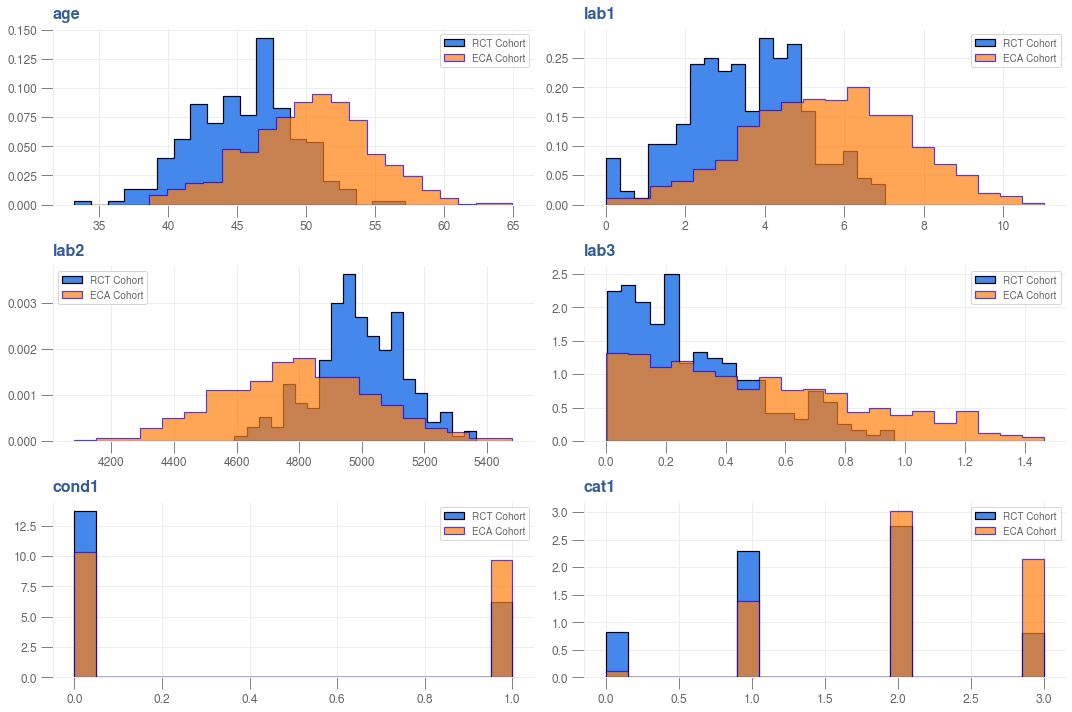

In [8]:
_, ax = plt.subplots(3,2, figsize=(15, 10))

data_base.name = 'RCT Cohort'
data_eca.name = 'ECA Cohort'
plot_dist(data_base, data_eca, 'age', ax[0][0])
plot_dist(data_base, data_eca, 'lab1', ax[0][1])
plot_dist(data_base, data_eca, 'lab2', ax[1][0])
plot_dist(data_base, data_eca, 'lab3', ax[1][1])
plot_dist(data_base, data_eca, 'cond1', ax[2][0])
plot_dist(data_base, data_eca, 'cat1', ax[2][1])

In [9]:
density_age = gaussian_kde(data_base['age'])
density_lab1 = gaussian_kde(data_base['lab1'])
density_lab2 = gaussian_kde(data_base['lab2'])
density_lab3 = gaussian_kde(data_base['lab3'])
density_cond1 = gaussian_kde(data_base['cond1'])
density_cat1 = gaussian_kde(data_base['cat1'])

In [10]:
b = max(data_base['age'].max(), data_eca['age'].max())
a = min(data_base['age'].min(), data_eca['age'].min())
waypoints_age = np.linspace(a, b, config['nwaypoints'])

b = max(data_base['lab1'].max(), data_eca['lab1'].max())
a = min(data_base['lab1'].min(), data_eca['lab1'].min())
waypoints_lab1 = np.linspace(a, b, config['nwaypoints'])

b = max(data_base['lab2'].max(), data_eca['lab2'].max())
a = min(data_base['lab2'].min(), data_eca['lab2'].min())
waypoints_lab2 = np.linspace(a, b, config['nwaypoints'])

b = max(data_base['lab3'].max(), data_eca['lab3'].max())
a = min(data_base['lab3'].min(), data_eca['lab3'].min())
waypoints_lab3 = np.linspace(a, b, config['nwaypoints'])

b = max(data_base['cond1'].max(), data_eca['cond1'].max())
a = min(data_base['cond1'].min(), data_eca['cond1'].min())
waypoints_cond1 = np.linspace(a, b, config['nwaypoints'])

b = max(data_base['cat1'].max(), data_eca['cat1'].max())
a = min(data_base['cat1'].min(), data_eca['cat1'].min())
waypoints_cat1 = np.linspace(a, b, config['nwaypoints'])

In [11]:
barwidth_age = np.diff(waypoints_age)[0]
barwidth_lab1 = np.diff(waypoints_lab1)[0]
barwidth_lab2 = np.diff(waypoints_lab2)[0]
barwidth_lab3 = np.diff(waypoints_lab3)[0]
barwidth_cond1 = np.diff(waypoints_cond1)[0]
barwidth_cat1 = np.diff(waypoints_cat1)[0]

In [12]:
kde_age = density_age(waypoints_age)*barwidth_age
kde_lab1 = density_lab1(waypoints_lab1)*barwidth_lab1
kde_lab2 = density_lab2(waypoints_lab2)*barwidth_lab2
kde_lab3 = density_lab3(waypoints_lab3)*barwidth_lab3
kde_cond1 = density_cond1(waypoints_cond1)*barwidth_cond1
kde_cat1 = density_cat1(waypoints_cat1)*barwidth_cat1

In [13]:
def calc_loss(w):  
    est_den_age = gaussian_kde(data_eca['age'], weights=w)
    est_den_lab1 = gaussian_kde(data_eca['lab1'], weights=w)
    est_den_lab2 = gaussian_kde(data_eca['lab2'], weights=w)
    est_den_lab3 = gaussian_kde(data_eca['lab3'], weights=w)
    est_den_cond1 = gaussian_kde(data_eca['cond1'], weights=w)
    est_den_cat1 = gaussian_kde(data_eca['cat1'], weights=w)
    
    if config['optimizeon'] == 'leastsquares':
        loss = ((kde_age - est_den_age(waypoints_age))*barwidth_age)**2 + \
        ((kde_lab1 - est_den_lab1(waypoints_lab1))*barwidth_lab1)**2 + \
        ((kde_lab2 - est_den_lab2(waypoints_lab2))*barwidth_lab2)**2 + \
        ((kde_lab3 - est_den_lab3(waypoints_lab3))*barwidth_lab3)**2 + \
        ((kde_cond1 - est_den_cond1(waypoints_cond1))*barwidth_cond1)**2 + \
        ((kde_cat1 - est_den_cat1(waypoints_cat1))*barwidth_cat1)**2
        
        return loss
    
    elif config['optimizeon'] == 'rel_entr':
        loss = rel_entr(kde_age, est_den_age(waypoints_age)*barwidth_age) + \
               rel_entr(kde_lab1, est_den_lab1(waypoints_lab1)*barwidth_lab1) + \
               rel_entr(kde_lab2, est_den_lab2(waypoints_lab2)*barwidth_lab2) + \
               rel_entr(kde_lab3, est_den_lab3(waypoints_lab3)*barwidth_lab3) + \
               rel_entr(kde_cond1, est_den_cond1(waypoints_cond1)*barwidth_cond1) + \
               rel_entr(kde_cat1, est_den_cat1(waypoints_cat1)*barwidth_cat1)
        return loss
        
    elif config['optimizeon'] == 'entropy':
        loss = entropy(kde_age, est_den_age(waypoints_age)*barwidth_age) + \
               entropy(kde_lab1, est_den_lab1(waypoints_lab1)*barwidth_lab1) + \
               entropy(kde_lab2, est_den_lab2(waypoints_lab2)*barwidth_lab2) + \
               entropy(kde_lab3, est_den_lab3(waypoints_lab3)*barwidth_lab3) + \
               entropy(kde_cond1, est_den_cond1(waypoints_cond1)*barwidth_cond1) + \
               entropy(kde_cat1, est_den_cat1(waypoints_cat1)*barwidth_cat1)
        return loss
    else:
        raise NotImplemented

In [14]:
bounds = list(zip(np.zeros(config['neca']), np.ones(config['neca'])))

In [15]:
%%time
weights = np.ones(config['neca'])/config['neca']

# wopt = minimize(calc_loss, weights, options= {'maxiter': 10000, 'disp': True},
#             bounds=bounds, method="L-BFGS-B")
wopt = minimize(calc_loss, weights, 
                options={'maxfun': 1e6, 'maxiter': 1000, 'disp': True,
                         'gtol':1e-5},
                bounds=bounds, method="L-BFGS-B")
p = wopt.x/sum(wopt.x)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30228D+00    |proj g|=  9.99000D-01

At iterate    1    f=  7.23789D-01    |proj g|=  6.69694D-03

At iterate    2    f=  7.21205D-01    |proj g|=  6.71242D-03
  ys=-9.882E-06  -gs= 2.579E-03 BFGS update SKIPPED

At iterate    3    f=  7.18572D-01    |proj g|=  6.72870D-03
  ys=-1.046E-05  -gs= 2.628E-03 BFGS update SKIPPED

At iterate    4    f=  7.16334D-01    |proj g|=  6.74231D-03
  ys=-7.562E-06  -gs= 2.234E-03 BFGS update SKIPPED

At iterate    5    f=  7.16066D-01    |proj g|=  6.74396D-03
  ys=-1.066E-07  -gs= 2.678E-04 BFGS update SKIPPED

At iterate    6    f=  7.13134D-01    |proj g|=  6.76199D-03
  ys=-1.304E-05  -gs= 2.926E-03 BFGS update SKIPPED

At iterate    7    f=  7.10789D-01    |proj g|=  6.77645D-03
  ys=-8.335E-06  -gs= 2.340E-03 BFGS update SKIPPED

At iterate    8    f=  7


At iterate   72    f=  4.81736D-01    |proj g|=  7.79186D-03
  ys=-5.694E-05  -gs= 5.321E-03 BFGS update SKIPPED

At iterate   73    f=  4.73936D-01    |proj g|=  7.26750D-03
  ys=-1.215E-04  -gs= 7.739E-03 BFGS update SKIPPED

At iterate   74    f=  4.73544D-01    |proj g|=  7.27057D-03
  ys=-3.197E-07  -gs= 3.924E-04 BFGS update SKIPPED

At iterate   75    f=  4.68480D-01    |proj g|=  7.31050D-03
  ys=-5.265E-05  -gs= 5.037E-03 BFGS update SKIPPED

At iterate   76    f=  4.64281D-01    |proj g|=  6.85174D-03
  ys=-3.619E-05  -gs= 4.181E-03 BFGS update SKIPPED

At iterate   77    f=  4.63891D-01    |proj g|=  6.85711D-03
  ys=-3.191E-07  -gs= 3.898E-04 BFGS update SKIPPED

At iterate   78    f=  4.61109D-01    |proj g|=  6.89558D-03
  ys=-1.622E-05  -gs= 2.774E-03 BFGS update SKIPPED

At iterate   79    f=  4.59488D-01    |proj g|=  6.91824D-03
  ys=-5.481E-06  -gs= 1.618E-03 BFGS update SKIPPED

At iterate   80    f=  4.57562D-01    |proj g|=  6.94503D-03
  ys=-7.882E-06  -gs= 1.92


At iterate  144    f=  3.11507D-01    |proj g|=  6.60552D-03
  ys=-1.733E-05  -gs= 2.777E-03 BFGS update SKIPPED

At iterate  145    f=  3.10466D-01    |proj g|=  6.62326D-03
  ys=-2.516E-06  -gs= 1.039E-03 BFGS update SKIPPED

At iterate  146    f=  3.10154D-01    |proj g|=  6.62862D-03
  ys=-2.229E-07  -gs= 3.125E-04 BFGS update SKIPPED

At iterate  147    f=  3.09845D-01    |proj g|=  6.63402D-03
  ys=-2.330E-07  -gs= 3.079E-04 BFGS update SKIPPED

At iterate  148    f=  3.06967D-01    |proj g|=  6.68480D-03
  ys=-2.004E-05  -gs= 2.869E-03 BFGS update SKIPPED

At iterate  149    f=  3.06411D-01    |proj g|=  6.69474D-03
  ys=-7.240E-07  -gs= 5.557E-04 BFGS update SKIPPED

At iterate  150    f=  3.05625D-01    |proj g|=  6.70881D-03
  ys=-1.483E-06  -gs= 7.853E-04 BFGS update SKIPPED

At iterate  151    f=  3.05054D-01    |proj g|=  6.71898D-03
  ys=-7.831E-07  -gs= 5.698E-04 BFGS update SKIPPED

At iterate  152    f=  3.03328D-01    |proj g|=  6.75032D-03
  ys=-7.236E-06  -gs= 1.72


At iterate  216    f=  2.18863D-01    |proj g|=  5.55164D-03
  ys=-1.730E-05  -gs= 2.406E-03 BFGS update SKIPPED

At iterate  217    f=  2.18710D-01    |proj g|=  5.55206D-03
  ys=-7.174E-08  -gs= 1.536E-04 BFGS update SKIPPED

At iterate  218    f=  2.17461D-01    |proj g|=  5.55458D-03
  ys=-4.635E-06  -gs= 1.247E-03 BFGS update SKIPPED

At iterate  219    f=  2.17318D-01    |proj g|=  5.55451D-03
  ys=-6.153E-08  -gs= 1.427E-04 BFGS update SKIPPED

At iterate  220    f=  2.16031D-01    |proj g|=  5.55332D-03
  ys=-4.784E-06  -gs= 1.285E-03 BFGS update SKIPPED

At iterate  221    f=  2.14157D-01    |proj g|=  5.54846D-03
  ys=-1.013E-05  -gs= 1.868E-03 BFGS update SKIPPED

At iterate  222    f=  2.12236D-01    |proj g|=  5.54087D-03
  ys=-1.049E-05  -gs= 1.916E-03 BFGS update SKIPPED

At iterate  223    f=  2.12035D-01    |proj g|=  5.53976D-03
  ys=-1.128E-07  -gs= 2.008E-04 BFGS update SKIPPED

At iterate  224    f=  2.09679D-01    |proj g|=  5.52313D-03
  ys=-1.525E-05  -gs= 2.34


At iterate  300    f=  8.36351D-02    |proj g|=  2.74908D-03

At iterate  301    f=  8.33206D-02    |proj g|=  2.76331D-03

At iterate  302    f=  8.29657D-02    |proj g|=  2.50868D-03

At iterate  303    f=  8.26151D-02    |proj g|=  1.83713D-03

At iterate  304    f=  8.23842D-02    |proj g|=  1.48353D-03

At iterate  305    f=  8.22455D-02    |proj g|=  1.58500D-03

At iterate  306    f=  8.20806D-02    |proj g|=  2.27966D-03

At iterate  307    f=  8.18764D-02    |proj g|=  2.21543D-03

At iterate  308    f=  8.16801D-02    |proj g|=  1.67917D-03

At iterate  309    f=  8.16361D-02    |proj g|=  1.59431D-03

At iterate  310    f=  8.15587D-02    |proj g|=  1.27539D-03

At iterate  311    f=  8.15379D-02    |proj g|=  1.20898D-03

At iterate  312    f=  8.13732D-02    |proj g|=  1.07141D-03

At iterate  313    f=  8.12691D-02    |proj g|=  1.02707D-03

At iterate  314    f=  8.11352D-02    |proj g|=  1.04329D-03

At iterate  315    f=  8.10829D-02    |proj g|=  1.14573D-03

At iter


At iterate  433    f=  7.92567D-02    |proj g|=  7.85623D-04

At iterate  434    f=  7.92552D-02    |proj g|=  2.77937D-04

At iterate  435    f=  7.92551D-02    |proj g|=  2.56332D-04

At iterate  436    f=  7.92550D-02    |proj g|=  2.38598D-04

At iterate  437    f=  7.92546D-02    |proj g|=  2.33287D-04

At iterate  438    f=  7.92533D-02    |proj g|=  2.42011D-04

At iterate  439    f=  7.92526D-02    |proj g|=  2.50021D-04

At iterate  440    f=  7.92515D-02    |proj g|=  2.31319D-04

At iterate  441    f=  7.92502D-02    |proj g|=  2.56381D-04

At iterate  442    f=  7.92489D-02    |proj g|=  2.60816D-04

At iterate  443    f=  7.92481D-02    |proj g|=  2.16738D-04

At iterate  444    f=  7.92479D-02    |proj g|=  1.74864D-04

At iterate  445    f=  7.92477D-02    |proj g|=  1.62727D-04

At iterate  446    f=  7.92472D-02    |proj g|=  1.36535D-04

At iterate  447    f=  7.92465D-02    |proj g|=  9.12340D-05

At iterate  448    f=  7.92461D-02    |proj g|=  9.11687D-05

At iter

In [16]:
print(wopt.success)

True


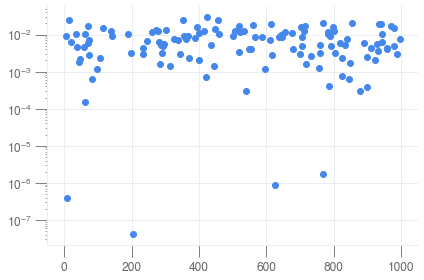

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(np.arange(0, config['neca']), p, marker='o')

ax.set_yscale('log')

In [18]:
data_eca_study = data_eca.sample(n=config['nbase'], replace=True, weights=p, 
                                 random_state=42)
data_eca_study.name = 'Optimized ECA Cohort'

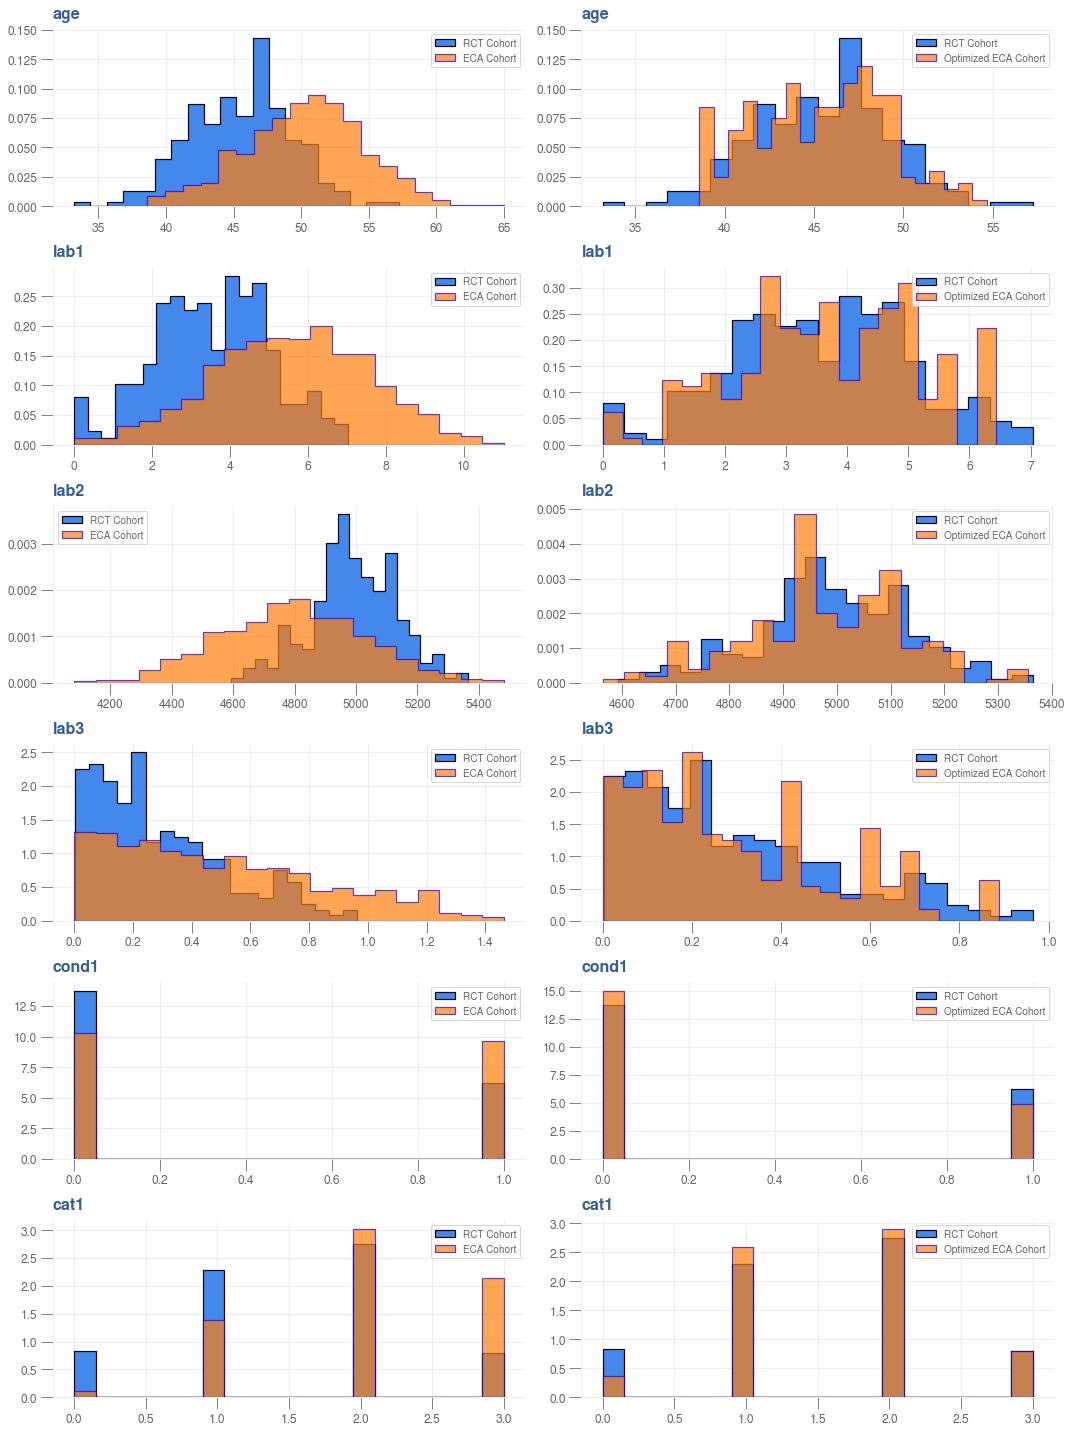

In [19]:
_, ax = plt.subplots(6,2, figsize=(15, 20))

for i, col in enumerate(data_base.columns):
    plot_dist(data_base, data_eca, col, ax[i][0])
    plot_dist(data_base, data_eca_study, col, ax[i][1])

In [20]:
for col in data_base.columns:
    print(f'Distribution of {col}')
    print('Before balancing', ks_2samp(data_base[col], data_eca[col]))
    print('After balancing', ks_2samp(data_base[col], data_eca_study[col]))
    print('\n')

Distribution of age
Before balancing KstestResult(statistic=0.484, pvalue=1.1790546311877907e-43)
After balancing KstestResult(statistic=0.052, pvalue=0.8888778031778077)


Distribution of lab1
Before balancing KstestResult(statistic=0.468, pvalue=1.1156813378131248e-40)
After balancing KstestResult(statistic=0.096, pvalue=0.19973993565508683)


Distribution of lab2
Before balancing KstestResult(statistic=0.463, pvalue=8.946608847415338e-40)
After balancing KstestResult(statistic=0.084, pvalue=0.3415239831286337)


Distribution of lab3
Before balancing KstestResult(statistic=0.284, pvalue=1.021405182655144e-14)
After balancing KstestResult(statistic=0.052, pvalue=0.8888778031778077)


Distribution of cond1
Before balancing KstestResult(statistic=0.172, pvalue=1.2858504509494217e-05)
After balancing KstestResult(statistic=0.064, pvalue=0.6862937345507706)


Distribution of cat1
Before balancing KstestResult(statistic=0.243, pvalue=7.887190900390806e-11)
After balancing KstestResult(stat

In [21]:
for col in data_base.columns:
    print(f'Distribution of {col}')
    print('Before balancing', cohensd(data_base[col], data_eca[col]))
    print('After balancing', cohensd(data_base[col], data_eca_study[col]))
    print('\n')

Distribution of age
Before balancing -1.162070634732194
After balancing 0.01965248335650374


Distribution of lab1
Before balancing -1.1534051605460736
After balancing -0.10463053598891808


Distribution of lab2
Before balancing 1.0051094045314761
After balancing 0.09979832791046638


Distribution of lab3
Before balancing -0.6816860655591704
After balancing -0.011835765526846488


Distribution of cond1
Before balancing -0.35694174231575576
After balancing 0.1429027185937808


Distribution of cat1
Before balancing -0.6782289027397312
After balancing -0.11303815045662195




In [22]:
w = wopt.x
calc_loss(w)

0.07924239558510132

In [23]:
est_den_age = gaussian_kde(data_eca['age'], weights=w)
est_den_lab1 = gaussian_kde(data_eca['lab1'], weights=w)
est_den_lab2 = gaussian_kde(data_eca['lab2'], weights=w)
est_den_lab3 = gaussian_kde(data_eca['lab3'], weights=w)
est_den_cond1 = gaussian_kde(data_eca['cond1'], weights=w)
est_den_cat1 = gaussian_kde(data_eca['cat1'], weights=w)

In [24]:
entropy(kde_age, est_den_age(waypoints_age)*barwidth_age)

0.01324775879898937

In [25]:
entropy(kde_lab1, est_den_lab1(waypoints_lab1)*barwidth_lab1)

0.007546171145804615

In [26]:
entropy(kde_lab2, est_den_lab2(waypoints_lab2)*barwidth_lab2)

0.0037505831009524582

In [27]:
entropy(kde_lab3, est_den_lab3(waypoints_lab3)*barwidth_lab3)

0.0029051397990564154

In [28]:
entropy(kde_cond1, est_den_cond1(waypoints_cond1)*barwidth_cond1)

0.033471226750373784

In [29]:
entropy(kde_cat1, est_den_cat1(waypoints_cat1)*barwidth_cat1)

0.018321515989924674

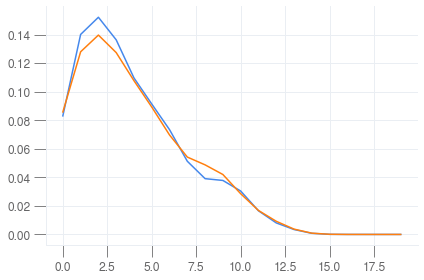

In [30]:
plt.plot(kde_lab3)
plt.plot(est_den_lab3(waypoints_lab3)*barwidth_lab3)